Import Libraries

In [1]:
import os
import json
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



Install Kaggle

In [13]:
!pip install kaggle

Load Kaggle Credentials

In [14]:
kaggle_credentails = json.load(open("kaggle.json"))

Set Kaggle API Environment Variables

In [15]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

Download Kaggle Dataset

In [2]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


Extract Kaggle Dataset

In [3]:
with ZipFile("gtsrb-german-traffic-sign.zip", 'r') as zip_ref:
    zip_ref.extractall("Data")

Data Initialization

In [4]:
path = "Data/Train"
labelFile = 'label_map.csv'
batch_size_val=32
epochs_val=10
imageDimesions = (32,32,3)
testRatio = 0.2
validationRatio = 0.2

Load and Preprocess Images

In [5]:
count = 0
images = []
classNo = []
target_shape = (32, 32)
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        img = cv2.imread(path+"/"+str(count)+"/"+y)
        img_resized = cv2.resize(img, target_shape)
        images.append(img_resized)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


Split Data into Train, Test, and Validation Sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

Print Data Shapes

In [7]:
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

Data Shapes
Train(25093, 32, 32, 3) (25093,)
Validation(6274, 32, 32, 3) (6274,)
Test(7842, 32, 32, 3) (7842,)


Load and Print Label Data

In [8]:
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


Set Up Sampling Parameters

In [9]:
num_of_samples = []
cols = 5
num_classes = noOfClasses

Define Preprocessing Functions

In [10]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

Apply Preprocessing to Data

In [11]:
X_train=np.array(list(map(preprocessing,X_train)))
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))

Reshape Data for Model

In [12]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

Data Augmentation and Batch Generation

In [13]:
dataGen= ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch = next(batches)

Convert Labels to Categorical

In [14]:
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

Define Model Architecture

In [15]:
def myModel():
    model= Sequential()
    model.add((Conv2D(60,(5,5),input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(60, (5,5), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add((Conv2D(30, (3,3),activation='relu')))
    model.add((Conv2D(30, (3,3), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses,activation='softmax'))
    model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model


Model Summary

In [16]:
model = myModel()
model.summary()

c:\Users\hkg20\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

Train Model with Early Stopping and Learning Rate Scheduler

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                    steps_per_epoch=len(X_train) // batch_size_val,
                    epochs=epochs_val,
                    validation_data=(X_validation, y_validation),
                    callbacks=[early_stopping, reduce_lr],
                    shuffle=True)


Epoch 1/10


c:\Users\hkg20\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


784/784 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.1717 - loss: 3.0582 - val_accuracy: 0.7938 - val_loss: 0.7028 - learning_rate: 0.0010
Epoch 2/10
  1/784 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.8125 - loss: 1.4979

c:\Users\hkg20\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


784/784 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8125 - loss: 1.4979 - val_accuracy: 0.8008 - val_loss: 0.7366 - learning_rate: 0.0010
Epoch 3/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - accuracy: 0.5995 - loss: 1.3279 - val_accuracy: 0.9119 - val_loss: 0.3131 - learning_rate: 0.0010
Epoch 4/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7500 - loss: 0.7646 - val_accuracy: 0.9117 - val_loss: 0.3066 - learning_rate: 0.0010
Epoch 5/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 68s 87ms/step - accuracy: 0.7338 - loss: 0.8500 - val_accuracy: 0.9433 - val_loss: 0.2129 - learning_rate: 0.0010
Epoch 6/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8125 - loss: 0.6145 - val_accuracy: 0.9449 - val_loss: 0.2110 - learning_rate: 0.0010
Epoch 7/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.7843 - loss: 0.6855 - val_accuracy: 0.9571 - val_loss: 0.1462 - learning_rate: 0.0010
Epoch 8/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7188 - loss: 0.9028 - val_a

Plot Training History and Evaluate Model

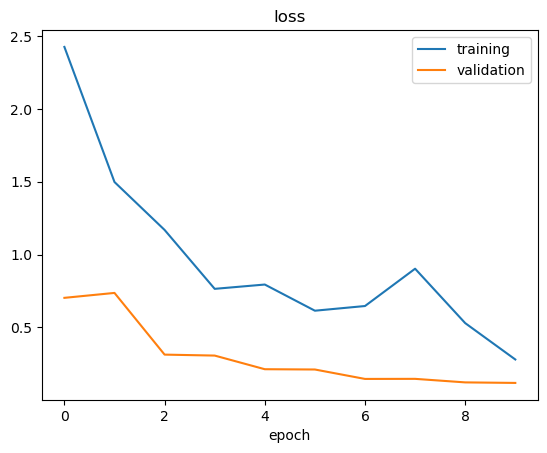

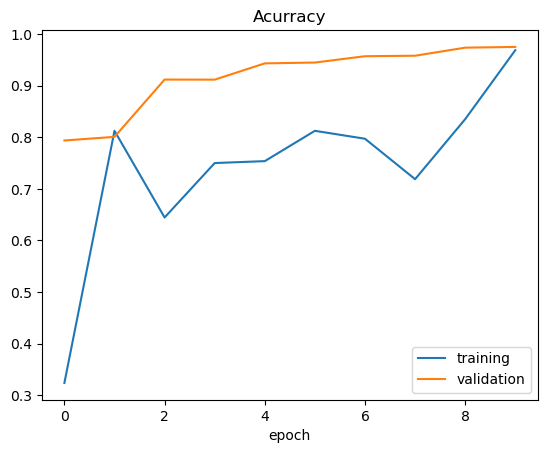

Test Score: 0.1143370196223259
Test Accuracy: 0.9736036658287048


In [27]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

Save Model

In [28]:
model.save("model.h5")

Predict and Extract Classes from Test Data

In [19]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


Confusion Matrix

In [20]:
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[ 46   3   1 ...   0   0   0]
 [  1 445   6 ...   1   0   0]
 [  0   1 434 ...   0   0   0]
 ...
 [  0   0   0 ...  72   0   1]
 [  0   0   0 ...   0  46   0]
 [  0   0   0 ...   0   0  41]]


Classification Report

In [21]:
label_map = dict(zip(data['Label'], data['Class Name']))
class_report = classification_report(Y_true, Y_pred_classes, target_names=[label_map[i] for i in range(noOfClasses)])
print("Classification Report:\n", class_report)

Classification Report:
                               precision    recall  f1-score   support

                    20_speed       0.98      0.92      0.95        50
                    30_speed       0.99      0.95      0.97       466
                    50_speed       0.98      0.98      0.98       444
                    60_speed       0.97      0.99      0.98       295
                    70_speed       0.98      0.99      0.99       389
                    80_speed       0.93      0.98      0.96       391
                   80_lifted       1.00      1.00      1.00        84
                   100_speed       0.98      0.96      0.97       297
                   120_speed       0.98      1.00      0.99       266
       no_overtaking_general       0.99      1.00      0.99       294
        no_overtaking_trucks       1.00      0.99      1.00       390
       right_of_way_crossing       0.95      1.00      0.97       253
        right_of_way_general       0.99      0.98      0.99      

Visualize Confusion Matrix

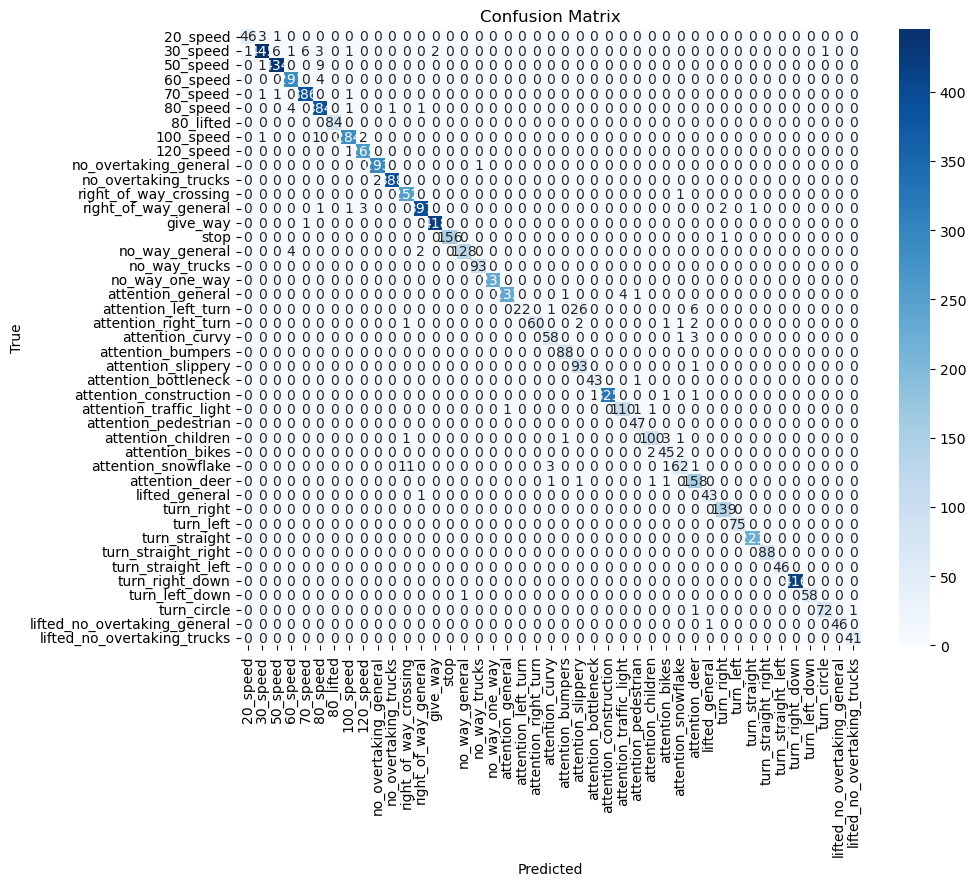

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Functions to Test Model

In [23]:
import numpy as np
import cv2
from keras.models import load_model

# Load the trained model
model = load_model('model.h5')

# Function to preprocess the input image

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (32, 32))
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    image_equalized = cv2.equalizeHist(image_gray)
    image_normalized = image_equalized / 255.0
    image_final = image_normalized.reshape(1, 32, 32, 1)
    return image_final

# Function to predict the label of the image
def predict_image_label(image_path):
    image = preprocess_image(image_path)
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions)
    return predicted_class



Printing image to be tested

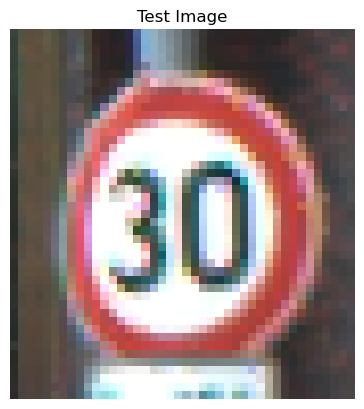

In [24]:
img = cv2.imread('Data/Test/00001.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.title('Test Image') 
plt.axis('off') # Hide axes 
plt.show()

Predicting the Image

In [25]:
# Example usage
image_path = 'Data/Test/00001.png'
predicted_label = predict_image_label(image_path)
print(f"The predicted label for the image is: {label_map[predicted_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
The predicted label for the image is: 30_speed
